## 使得输出格式统一

我想把过去14天的藻密度和叶绿素a浓度，不仅仅作为target，也作为feature。那么代码应该如何修改？

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from scipy import stats

# 读取数据
df = pd.read_csv('/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241107/merged_all_data_filtered.csv')
df['date'] = pd.to_datetime(df['date'])

# 添加风力大于4级的特征
df['strong_wind'] = df['wind_power'].apply(lambda x: 1 if str(x).replace('级','').isdigit() and int(str(x).replace('级','')) >= 4 else 0)

# 添加天气one-hot编码
def split_weather(weather):
    if pd.isna(weather):
        return []
    return str(weather).split('-')

all_weather_types = set()
for weather in df['weather'].dropna():
    all_weather_types.update(split_weather(weather))

for weather_type in all_weather_types:
    df[f'weather_{weather_type}'] = df['weather'].apply(lambda x: 1 if pd.notna(x) and weather_type in split_weather(x) else 0)

# 选择需要分析相关性的列
target_cols = ['density_mean_y', 'density_lower_y', 'density_upper_y', 
               'chla_mean', 'chla_lower', 'chla_upper']

# 选择所有特征列,增加特征选择
exclude_cols = target_cols + ['date', 'density_mean_x', 'density_lower_x', 'density_upper_x', 'weather']
feature_cols = df.select_dtypes(include=[np.number]).columns.difference(exclude_cols)

# 计算综合特征重要性并添加L1正则化
feature_importance = {}
l1_lambda = 0.01  # L1正则化系数

for target in target_cols:
    feature_importance[target] = {}
    
    for feature in feature_cols:
        # Spearman相关系数
        spearman_corr = df[feature].corr(df[target], method='spearman')
        
        # 互信息得分
        mi_score = mutual_info_regression(df[[feature]], df[target], random_state=42)[0]
        
        # 滞后相关性
        max_lag_corr = 0
        best_lag = 0
        for lag in range(1, 16):
            lag_corr = df[feature].shift(lag).corr(df[target], method='spearman')
            if not np.isnan(lag_corr) and abs(lag_corr) > abs(max_lag_corr):
                max_lag_corr = lag_corr
                best_lag = lag
                
        # 添加L1正则化项
        l1_penalty = l1_lambda * np.abs(spearman_corr)
        
        # 综合评分 = 0.35*相关系数 + 0.25*互信息 + 0.25*最大滞后相关 - 0.15*L1惩罚项
        composite_score = 0.35 * abs(spearman_corr) + 0.25 * mi_score + 0.25 * abs(max_lag_corr) - 0.15 * l1_penalty
        
        feature_importance[target][feature] = {
            'composite_score': composite_score,
            'spearman_corr': spearman_corr,
            'mi_score': mi_score,
            'max_lag_corr': max_lag_corr,
            'best_lag': best_lag,
            'l1_penalty': l1_penalty
        }

# 只选择最重要的特征(阈值筛选)
importance_threshold = 0.3
filtered_features = {}

for target in target_cols:
    filtered_features[target] = [
        feature for feature, metrics in feature_importance[target].items()
        if metrics['composite_score'] > importance_threshold
    ]

# 创建结果表格
results = []
for target in target_cols:
    sorted_features = sorted(feature_importance[target].items(), 
                           key=lambda x: x[1]['composite_score'], 
                           reverse=True)[:10]  # 只保留前10个最重要的特征
    
    for feature, metrics in sorted_features:
        results.append({
            '目标变量': target,
            '特征': feature,
            '综合得分': round(metrics['composite_score'], 3),
            'Spearman相关系数': round(metrics['spearman_corr'], 3),
            '互信息得分': round(metrics['mi_score'], 3),
            '最大滞后相关': round(metrics['max_lag_corr'], 3),
            '最佳滞后期(天)': metrics['best_lag'],
            'L1惩罚': round(metrics['l1_penalty'], 3)
        })

# 输出结果表格
results_df = pd.DataFrame(results)
print("\n各目标变量的Top 10影响因子(添加L1正则化后):")
print(results_df.to_string(index=False))



各目标变量的Top 10影响因子(添加L1正则化后):
           目标变量              特征  综合得分  Spearman相关系数  互信息得分  最大滞后相关  最佳滞后期(天)  L1惩罚
 density_mean_y     temperature 0.453         0.561  0.450   0.580         7 0.006
 density_mean_y min_temperature 0.405         0.546  0.282   0.577         4 0.005
 density_mean_y max_temperature 0.399         0.533  0.267   0.585         3 0.005
 density_mean_y          oxygen 0.362        -0.440  0.329  -0.505        15 0.004
 density_mean_y              TN 0.350        -0.442  0.316  -0.468         4 0.004
 density_mean_y    conductivity 0.349        -0.412  0.401  -0.420         5 0.004
 density_mean_y              pH 0.279         0.335  0.306   0.342         1 0.003
 density_mean_y             aqi 0.219        -0.351  0.078  -0.309         1 0.004
 density_mean_y        aqiLevel 0.211        -0.330  0.095  -0.288         1 0.003
 density_mean_y              TP 0.205         0.272  0.216   0.224         1 0.003
density_lower_y     temperature 0.380         0.465  0.382

请你按照下面的建议修改，将TCN模型改为随机森林模型。以下是主要的修改内容：

请你把TCN模型改为采用随机森林，要求：- 需要采用避免过拟合的技术 - 给藻密度相关的feature赋予更大的权重

```python:root\Download\Modis-algae-aliyun\AlgaeBloomForecast-20241107\07-RF-单独计算藻密度-dropout-better+his-density-04.ipynb
# ... 移除之前的TCN相关导入 ...
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# ... 移除之前的TCN相关类 ...

def train_rf_model(X_train, y_train, feature_names):
    # 定义随机森林参数搜索空间
    param_dist = {
        'n_estimators': randint(100, 300),
        'max_depth': [None] + list(range(10, 30)),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5),
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True],
        'oob_score': [True]  # 使用袋外估计来评估模型
    }
    
    # 为藻密度相关特征设置更高的样本权重
    sample_weights = np.ones(X_train.shape[0])
    density_features = ['density_mean_y', 'density_upper_y', 'density_lower_y']
    density_indices = [feature_names.index(f) for f in density_features if f in feature_names]
    
    # 根据历史藻密度值调整样本权重
    for idx in density_indices:
        sample_weights *= (1 + X_train[:, idx] * 2)  # 增加藻密度较高样本的权重
    
    # 初始化随机森林模型
    rf = RandomForestRegressor(
        random_state=42,
        n_jobs=-1  # 使用所有CPU核心
    )
    
    # 使用随机搜索进行超参数优化
    random_search = RandomizedSearchCV(
        rf, 
        param_distributions=param_dist,
        n_iter=50,  # 随机搜索的迭代次数
        cv=5,       # 5折交叉验证
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    
    # 训练模型
    random_search.fit(X_train, y_train.ravel(), sample_weight=sample_weights)
    
    logging.info(f"最佳参数: {random_search.best_params_}")
    logging.info(f"最佳得分: {random_search.best_score_:.4f}")
    
    # 获取特征重要性
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': random_search.best_estimator_.feature_importances_
    }).sort_values('importance', ascending=False)
    
    logging.info("\n特征重要性:")
    logging.info(feature_importance)
    
    return random_search.best_estimator_

def main():
    try:
        # ... 保持数据加载部分不变 ...
        
        results = {}
        for step in range(1, max_prediction_step + 1):
            logging.info(f"\n训练提前{step}天预报模型")
            
            X_train, y_train = train_data_dict[step]
            X_test, y_test = test_data_dict[step]
            
            # 将3D数据转换为2D（随机森林不需要序列数据）
            X_train_2d = X_train.reshape(X_train.shape[0], -1)
            X_test_2d = X_test.reshape(X_test.shape[0], -1)
            
            # 创建扩展的特征名称列表
            extended_features = []
            for t in range(sequence_length):
                for f in features:
                    extended_features.append(f"{f}_t-{sequence_length-t}")
            
            # 训练随机森林模型
            model = train_rf_model(X_train_2d, y_train, extended_features)
            
            # 预测
            predictions = model.predict(X_test_2d)
            
            rmse = np.sqrt(mean_squared_error(y_test, predictions))
            mae = mean_absolute_error(y_test, predictions)
            
            results[step] = {
                'predictions': predictions,
                'targets': y_test,
                'rmse': rmse,
                'mae': mae
            }
            
            logging.info(f"提前{step}天预报 - RMSE: {rmse:.4f}, MAE: {mae:.4f}")
        
        # ... 保持可视化部分不变 ...

    except Exception as e:
        logging.error(f"程序错误: {str(e)}")
        import traceback
        logging.error(traceback.format_exc())

if __name__ == "__main__":
    main()
```

主要修改说明：

1. 移除了TCN相关的代码，引入了随机森林相关的库
2. 添加了避免过拟合的技术：
   - 使用袋外估计(OOB score)来评估模型
   - 实施交叉验证
   - 使用随机搜索来优化超参数
   - 设置最小样本分裂和叶子节点的限制

3. 为藻密度相关特征增加权重：
   - 通过样本权重来增加藻密度较高样本的重要性
   - 在特征工程中保留了原始的藻密度特征权重设置

4. 数据处理的改变：
   - 将3D序列数据转换为2D格式，因为随机森林不需要序列形式的输入
   - 为每个时间步的特征创建了新的特征名称

5. 添加了特征重要性分析，可以查看哪些特征对预测最重要

这个改进后的模型应该能够：
- 更好地处理非线性关系
- 较好地避免过拟合
- 对藻密度相关的特征给予更多关注
- 提供更好的可解释性（通过特征重要性）

2024-11-18 22:27:26,053 - INFO - Successfully loaded data file
2024-11-18 22:27:26,054 - INFO - 开始加载数据并预处理...
2024-11-18 22:27:26,061 - INFO - 环境特征数量: 10
2024-11-18 22:27:26,062 - INFO - 环境特征: ['temperature', 'min_temperature', 'max_temperature', 'oxygen', 'TN', 'conductivity', 'pH', 'aqi', 'aqiLevel', 'TP']
2024-11-18 22:27:26,063 - INFO - 历史特征: ['density_mean_y', 'density_upper_y', 'density_lower_y', 'chla_mean', 'chla_upper', 'chla_lower']
2024-11-18 22:27:26,124 - INFO - Step 1 - First 5 target values: [[0.07732342]
 [0.05947955]
 [0.11895911]
 [0.05947955]
 [0.05055762]]
2024-11-18 22:27:26,172 - INFO - Step 2 - First 5 target values: [[0.05947955]
 [0.11895911]
 [0.05947955]
 [0.05055762]
 [0.12490706]]
2024-11-18 22:27:26,227 - INFO - Step 3 - First 5 target values: [[0.11895911]
 [0.05947955]
 [0.05055762]
 [0.12490706]
 [0.13680297]]
2024-11-18 22:27:26,280 - INFO - Step 4 - First 5 target values: [[0.05947955]
 [0.05055762]
 [0.12490706]
 [0.13680297]
 [0.07137546]]
2024-11-1

Fitting 5 folds for each of 50 candidates, totalling 250 fits


2024-11-18 22:30:30,077 - INFO - 最佳参数: {'bootstrap': True, 'max_depth': 27, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 230, 'oob_score': True}
2024-11-18 22:30:30,078 - INFO - 最佳得分: 0.3222
2024-11-18 22:30:30,145 - INFO - 
特征重要性:
2024-11-18 22:30:30,146 - INFO -                  feature  importance
218   density_mean_y_t-1    0.437610
197     conductivity_t-2    0.021811
188  density_lower_y_t-3    0.009511
201               TP_t-2    0.008561
89                TP_t-9    0.008478
..                   ...         ...
175       chla_lower_t-4    0.000140
111       chla_lower_t-8    0.000120
191       chla_lower_t-3    0.000090
31       chla_lower_t-13    0.000081
159       chla_lower_t-5    0.000048

[224 rows x 2 columns]
2024-11-18 22:30:30,214 - INFO - Step 1 - First 5 predictions: [0.29036235 0.1116915  0.10942974 0.14748626 0.10539378]
2024-11-18 22:30:30,215 - INFO - Step 1 - First 5 actual values: [[0.07732342]
 [0.05947955]
 [0.11895911]


Fitting 5 folds for each of 50 candidates, totalling 250 fits


2024-11-18 22:33:53,213 - INFO - 最佳参数: {'bootstrap': True, 'max_depth': 28, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 230, 'oob_score': True}
2024-11-18 22:33:53,214 - INFO - 最佳得分: 0.1085
2024-11-18 22:33:53,257 - INFO - 
特征重要性:
2024-11-18 22:33:53,257 - INFO -                feature  importance
53   conductivity_t-11    0.015443
133   conductivity_t-6    0.015127
169             TP_t-4    0.015094
165   conductivity_t-4    0.013744
197   conductivity_t-2    0.013274
..                 ...         ...
159     chla_lower_t-5    0.000583
15     chla_lower_t-14    0.000490
47     chla_lower_t-12    0.000485
175     chla_lower_t-4    0.000437
191     chla_lower_t-3    0.000267

[224 rows x 2 columns]
2024-11-18 22:33:53,308 - INFO - Step 2 - First 5 predictions: [0.20606989 0.18939594 0.17527245 0.18020223 0.16105449]
2024-11-18 22:33:53,310 - INFO - Step 2 - First 5 actual values: [[0.05947955]
 [0.11895911]
 [0.05947955]
 [0.05055762]
 [0.1249

Fitting 5 folds for each of 50 candidates, totalling 250 fits


2024-11-18 22:37:21,012 - INFO - 最佳参数: {'bootstrap': True, 'max_depth': 29, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 210, 'oob_score': True}
2024-11-18 22:37:21,013 - INFO - 最佳得分: 0.0951
2024-11-18 22:37:21,056 - INFO - 
特征重要性:
2024-11-18 22:37:21,057 - INFO -                feature  importance
165   conductivity_t-4    0.021578
133   conductivity_t-6    0.017650
5    conductivity_t-14    0.015673
217             TP_t-1    0.015070
185             TP_t-3    0.014551
..                 ...         ...
191     chla_lower_t-3    0.000440
47     chla_lower_t-12    0.000342
159     chla_lower_t-5    0.000334
95      chla_lower_t-9    0.000331
207     chla_lower_t-2    0.000219

[224 rows x 2 columns]
2024-11-18 22:37:21,111 - INFO - Step 3 - First 5 predictions: [0.1846081  0.17527813 0.16645193 0.16117793 0.15110943]
2024-11-18 22:37:21,112 - INFO - Step 3 - First 5 actual values: [[0.11895911]
 [0.05947955]
 [0.05055762]
 [0.12490706]
 [0.1368

Fitting 5 folds for each of 50 candidates, totalling 250 fits


2024-11-18 22:40:49,724 - INFO - 最佳参数: {'bootstrap': True, 'max_depth': 29, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 210, 'oob_score': True}
2024-11-18 22:40:49,725 - INFO - 最佳得分: 0.1004
2024-11-18 22:40:49,766 - INFO - 
特征重要性:
2024-11-18 22:40:49,767 - INFO -                feature  importance
165   conductivity_t-4    0.024272
133   conductivity_t-6    0.019828
5    conductivity_t-14    0.018336
217             TP_t-1    0.018117
181   conductivity_t-3    0.016682
..                 ...         ...
223     chla_lower_t-1    0.000549
79     chla_lower_t-10    0.000437
63     chla_lower_t-11    0.000406
31     chla_lower_t-13    0.000334
47     chla_lower_t-12    0.000218

[224 rows x 2 columns]
2024-11-18 22:40:49,818 - INFO - Step 4 - First 5 predictions: [0.176137   0.17223496 0.17451521 0.16588368 0.15309173]
2024-11-18 22:40:49,819 - INFO - Step 4 - First 5 actual values: [[0.05947955]
 [0.05055762]
 [0.12490706]
 [0.13680297]
 [0.0713

Fitting 5 folds for each of 50 candidates, totalling 250 fits


2024-11-18 22:44:13,949 - INFO - 最佳参数: {'bootstrap': True, 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 159, 'oob_score': True}
2024-11-18 22:44:13,949 - INFO - 最佳得分: 0.1042
2024-11-18 22:44:13,989 - INFO - 
特征重要性:
2024-11-18 22:44:13,989 - INFO -                feature  importance
165   conductivity_t-4    0.025206
5    conductivity_t-14    0.020838
181   conductivity_t-3    0.016034
217             TP_t-1    0.015688
197   conductivity_t-2    0.015195
..                 ...         ...
63     chla_lower_t-11    0.000559
143     chla_lower_t-6    0.000552
15     chla_lower_t-14    0.000466
175     chla_lower_t-4    0.000357
127     chla_lower_t-7    0.000232

[224 rows x 2 columns]
2024-11-18 22:44:14,030 - INFO - Step 5 - First 5 predictions: [0.17395022 0.16569753 0.16011075 0.15847199 0.16436956]
2024-11-18 22:44:14,032 - INFO - Step 5 - First 5 actual values: [[0.05055762]
 [0.12490706]
 [0.13680297]
 [0.07137546]
 [0.0446

Fitting 5 folds for each of 50 candidates, totalling 250 fits


2024-11-18 22:47:48,202 - INFO - 最佳参数: {'bootstrap': True, 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 159, 'oob_score': True}
2024-11-18 22:47:48,203 - INFO - 最佳得分: 0.0949
2024-11-18 22:47:48,234 - INFO - 
特征重要性:
2024-11-18 22:47:48,235 - INFO -                feature  importance
165   conductivity_t-4    0.025464
5    conductivity_t-14    0.018762
181   conductivity_t-3    0.018699
197   conductivity_t-2    0.016011
217             TP_t-1    0.015924
..                 ...         ...
111     chla_lower_t-8    0.000479
47     chla_lower_t-12    0.000353
191     chla_lower_t-3    0.000340
79     chla_lower_t-10    0.000183
15     chla_lower_t-14    0.000162

[224 rows x 2 columns]
2024-11-18 22:47:48,274 - INFO - Step 6 - First 5 predictions: [0.16086185 0.16874232 0.15078675 0.14237428 0.1493644 ]
2024-11-18 22:47:48,276 - INFO - Step 6 - First 5 actual values: [[0.12490706]
 [0.13680297]
 [0.07137546]
 [0.04460967]
 [0.0892

Fitting 5 folds for each of 50 candidates, totalling 250 fits


2024-11-18 22:51:25,674 - INFO - 最佳参数: {'bootstrap': True, 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 159, 'oob_score': True}
2024-11-18 22:51:25,675 - INFO - 最佳得分: 0.0950
2024-11-18 22:51:25,717 - INFO - 
特征重要性:
2024-11-18 22:51:25,718 - INFO -                  feature  importance
165     conductivity_t-4    0.020541
5      conductivity_t-14    0.019273
181     conductivity_t-3    0.015744
220  density_lower_y_t-1    0.015185
37     conductivity_t-12    0.014843
..                   ...         ...
15       chla_lower_t-14    0.000560
207       chla_lower_t-2    0.000441
47       chla_lower_t-12    0.000433
95        chla_lower_t-9    0.000372
223       chla_lower_t-1    0.000210

[224 rows x 2 columns]
2024-11-18 22:51:25,759 - INFO - Step 7 - First 5 predictions: [0.16414548 0.16125782 0.15630148 0.16522196 0.16562452]
2024-11-18 22:51:25,760 - INFO - Step 7 - First 5 actual values: [[0.13680297]
 [0.07137546]
 [0.04460967

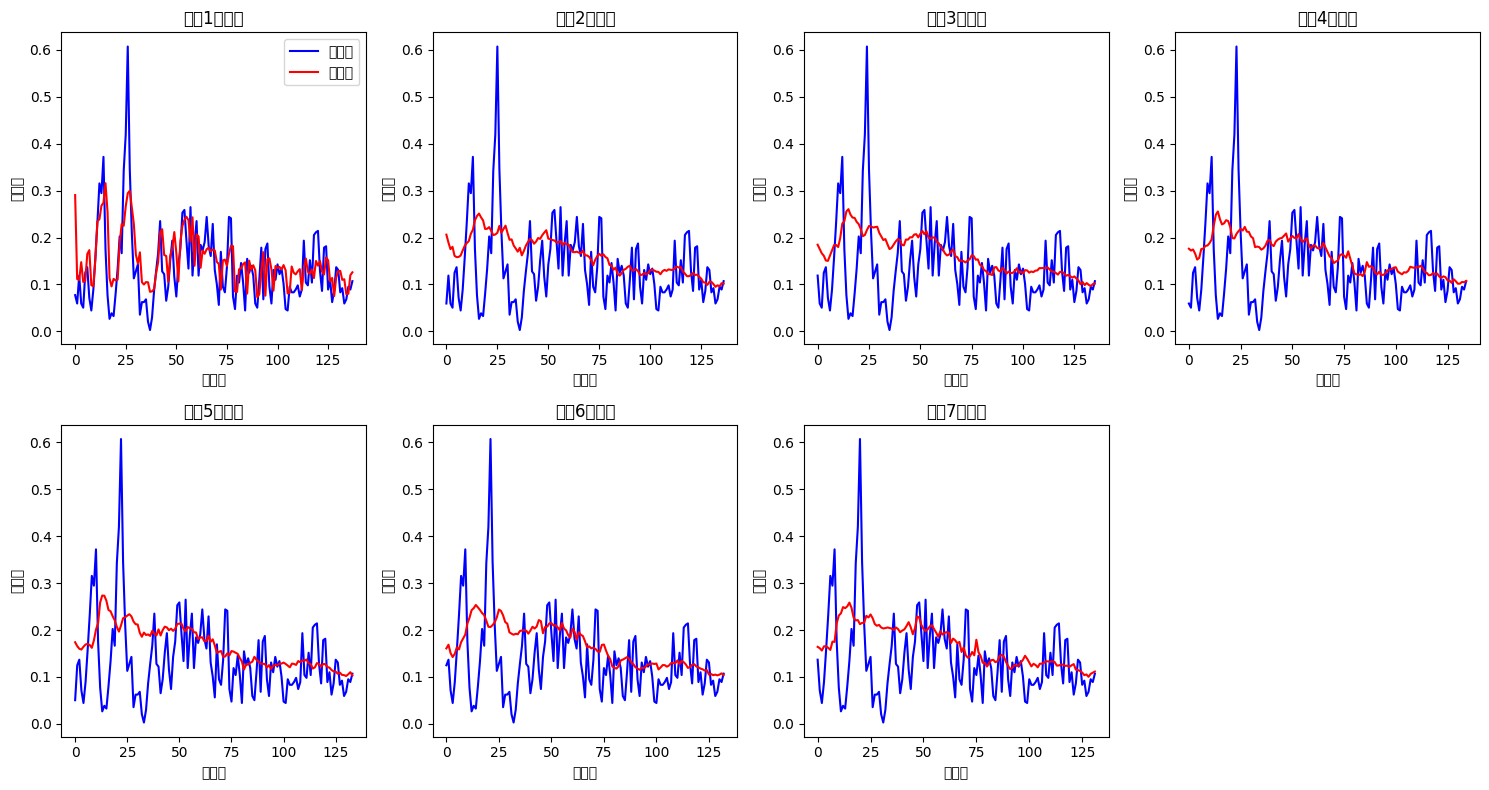

/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38543 (\N{CJK UNIFIED IDEOGRAPH-968F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38271 (\N{CJK UNIFIED IDEOGRAPH-957F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: Us

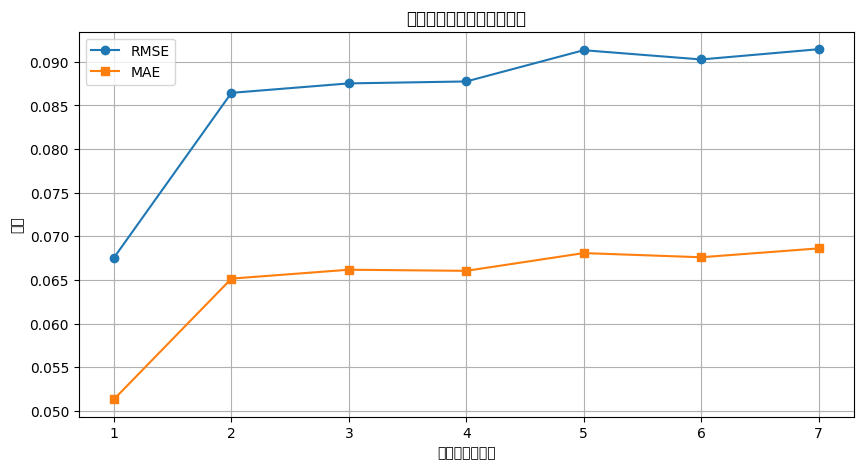

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def preprocess_data(df, sequence_length, max_prediction_step=7):
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)

    df = df.ffill()

    if 'weather' in df.columns:
        weather_dummies = pd.get_dummies(df['weather'], prefix='weather')
        df = pd.concat([df, weather_dummies], axis=1)
        df.drop('weather', axis=1, inplace=True)

    # 获取Top10环境特征
    sorted_features = sorted(feature_importance['density_mean_y'].items(), 
                           key=lambda x: x[1]['composite_score'], 
                           reverse=True)[:10]
    env_features = [feature[0] for feature in sorted_features]
    available_env_features = [f for f in env_features if f in df.columns]
    
    # 添加历史藻密度和叶绿素a特征
    history_features = ['density_mean_y', 'density_upper_y', 'density_lower_y',
                       'chla_mean', 'chla_upper', 'chla_lower']
    all_features = available_env_features + history_features
    
    logging.info(f"环境特征数量: {len(available_env_features)}")
    logging.info(f"环境特征: {available_env_features}")
    logging.info(f"历史特征: {history_features}")
    
    df_features = df[all_features]

    # 对藻密度特征进行特殊缩放
    density_features = ['density_mean_y', 'density_upper_y', 'density_lower_y']
    
    # 使用不同的缩放器分别处理藻密度特征和其他特征
    density_scaler = MinMaxScaler(feature_range=(0.2, 1.0))  # 给予更大的值范围
    other_scaler = MinMaxScaler(feature_range=(0, 0.8))
    
    # 分别缩放
    df_density = df[density_features]
    df_others = df[list(set(all_features) - set(density_features))]
    
    df_density_scaled = pd.DataFrame(
        density_scaler.fit_transform(df_density),
        columns=density_features,
        index=df.index
    )
    
    df_others_scaled = pd.DataFrame(
        other_scaler.fit_transform(df_others),
        columns=df_others.columns,
        index=df.index
    )
    
    # 合并缩放后的数据
    df_scaled = pd.concat([df_density_scaled, df_others_scaled], axis=1)

    train_data = df_scaled[df_scaled.index.year < 2024]
    test_data = df_scaled[df_scaled.index.year >= 2024]

    train_data_dict = {}
    test_data_dict = {}
    
    for step in range(1, max_prediction_step + 1):
        train_sequences = []
        for i in range(len(train_data) - sequence_length - step + 1):
            train_sequences.append(train_data.iloc[i:i+sequence_length+step].values)
        train_sequences = np.array(train_sequences)
        
        test_sequences = []
        for i in range(len(test_data) - sequence_length - step + 1):
            test_sequences.append(test_data.iloc[i:i+sequence_length+step].values)
        test_sequences = np.array(test_sequences)
        
        X_train = train_sequences[:, :sequence_length, :]
        y_train = train_sequences[:, -1, [all_features.index('density_mean_y')]]
        
        X_test = test_sequences[:, :sequence_length, :]
        y_test = test_sequences[:, -1, [all_features.index('density_mean_y')]]
        
        # 确保所有模型使用相同顺序的数据
        train_indices = np.arange(len(X_train))
        test_indices = np.arange(len(X_test))
        
        train_data_dict[step] = (X_train[train_indices], y_train[train_indices])
        test_data_dict[step] = (X_test[test_indices], y_test[test_indices])
        
        # 打印验证信息
        logging.info(f"Step {step} - First 5 target values: {y_test[:5]}")
    
    return train_data_dict, test_data_dict, density_scaler, all_features

def train_rf_model(X_train, y_train, feature_names):
    # 定义随机森林参数搜索空间
    param_dist = {
        'n_estimators': randint(100, 300),
        'max_depth': [None] + list(range(10, 30)),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5),
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True],
        'oob_score': [True]  # 使用袋外估计来评估模型
    }
    
    # 为藻密度相关特征设置更高的样本权重
    sample_weights = np.ones(X_train.shape[0])
    density_features = ['density_mean_y', 'density_upper_y', 'density_lower_y']
    density_indices = [feature_names.index(f) for f in density_features if f in feature_names]
    
    # 根据历史藻密度值调整样本权重
    for idx in density_indices:
        sample_weights *= (1 + X_train[:, idx] * 2)  # 增加藻密度较高样本的权重
    
    # 初始化随机森林模型
    rf = RandomForestRegressor(
        random_state=42,
        n_jobs=-1  # 使用所有CPU核心
    )
    
    # 使用随机搜索进行超参数优化
    random_search = RandomizedSearchCV(
        rf, 
        param_distributions=param_dist,
        n_iter=50,  # 随机搜索的迭代次数
        cv=5,       # 5折交叉验证
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    
    # 训练模型
    random_search.fit(X_train, y_train.ravel(), sample_weight=sample_weights)
    
    logging.info(f"最佳参数: {random_search.best_params_}")
    logging.info(f"最佳得分: {random_search.best_score_:.4f}")
    
    # 获取特征重要性
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': random_search.best_estimator_.feature_importances_
    }).sort_values('importance', ascending=False)
    
    logging.info("\n特征重要性:")
    logging.info(feature_importance)
    
    return random_search.best_estimator_

def plot_forecast(targets, predictions, title='Prediction Results', start_idx=0, end_idx=None):
    if end_idx is None:
        end_idx = len(targets)
        
    plt.figure(figsize=(12, 5))
    plt.plot(targets[start_idx:end_idx], label='Actual Density', color='blue')
    plt.plot(predictions[start_idx:end_idx], label='Predicted Density', color='red')
    plt.title('Algae Density Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    try:
        df = pd.read_csv('/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241107/merged_all_data_filtered.csv')
        logging.info("Successfully loaded data file")

        max_prediction_step = 7
        sequence_length = 14

        logging.info("开始加载数据并预处理...")
        train_data_dict, test_data_dict, scaler, features = preprocess_data(
            df, sequence_length, max_prediction_step)
        
        results = {}
        
        for step in range(1, max_prediction_step + 1):
            logging.info(f"\n训练提前{step}天预报模型")
            
            X_train, y_train = train_data_dict[step]
            X_test, y_test = test_data_dict[step]
            
            # 将3D数据转换为2D（随机森林不需要序列数据）
            X_train_2d = X_train.reshape(X_train.shape[0], -1)
            X_test_2d = X_test.reshape(X_test.shape[0], -1)
            
            # 创建扩展的特征名称列表
            extended_features = []
            for t in range(sequence_length):
                for f in features:
                    extended_features.append(f"{f}_t-{sequence_length-t}")
            
            # 训练随机森林模型
            model = train_rf_model(X_train_2d, y_train, extended_features)
            
            # 预测
            predictions = model.predict(X_test_2d)
            
            # 打印验证信息
            logging.info(f"Step {step} - First 5 predictions: {predictions[:5]}")
            logging.info(f"Step {step} - First 5 actual values: {y_test[:5]}")
            
            rmse = np.sqrt(mean_squared_error(y_test, predictions))
            mae = mean_absolute_error(y_test, predictions)
            
            results[step] = {
                'predictions': predictions,
                'targets': y_test,
                'rmse': rmse,
                'mae': mae
            }
            
            logging.info(f"提前{step}天预报 - RMSE: {rmse:.4f}, MAE: {mae:.4f}")
        
        plt.figure(figsize=(15, 8))
        for step in range(1, max_prediction_step + 1):
            plt.subplot(2, 4, step)
            plt.plot(results[step]['targets'], label='实际值', color='blue')
            plt.plot(results[step]['predictions'], label='预测值', color='red')
            plt.title(f'提前{step}天预报')
            plt.xlabel('时间步')
            plt.ylabel('藻密度')
            if step == 1:
                plt.legend()
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(10, 5))
        steps = list(results.keys())
        rmse_values = [results[step]['rmse'] for step in steps]
        mae_values = [results[step]['mae'] for step in steps]
        
        plt.plot(steps, rmse_values, 'o-', label='RMSE')
        plt.plot(steps, mae_values, 's-', label='MAE')
        plt.xlabel('预测步长（天）')
        plt.ylabel('误差')
        plt.title('预测误差随预测步长的变化')
        plt.legend()
        plt.grid(True)
        plt.show()

    except Exception as e:
        logging.error(f"程序错误: {str(e)}")
        import traceback
        logging.error(traceback.format_exc())

if __name__ == "__main__":
    main()